# Estimating Power without Measuring it: a Machine Learning Approach

G. Lemaitre and C. Lemaitre

Required import to check the results

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.metrics import median_absolute_error

%matplotlib inline

### Data loading

Load the ground-truth prediction

In [2]:
PATH_RESULT = 'results'

In [3]:
path_y_true = os.path.join(PATH_RESULT, 'machine_learning_model', 'y_true.csv')
y_true = pd.read_csv(path_y_true, index_col=0, parse_dates=True, header=None)

Load the predictions from the mathematical model

In [4]:
path_y_pred_math = os.path.join(PATH_RESULT, 'mathematical_model', 'y_pred.csv')
y_pred_math_model = pd.read_csv(path_y_pred_math, index_col=0, parse_dates=True, header=None)

Load the predictions from the machine learning model

In [5]:
path_y_pred_ml = os.path.join(PATH_RESULT, 'machine_learning_model', 'y_pred.csv')
y_pred_ml_model = pd.read_csv(path_y_pred_ml, index_col=0, parse_dates=True, header=None)

Load the information regarding which samples corresponds to which ride

In [6]:
path_groups = os.path.join(PATH_RESULT, 'machine_learning_model', 'groups.npy')
groups_ride = np.load(path_groups)

Load the information regarding the altitude to observe potential artifacts

In [7]:
path_altitude = os.path.join(PATH_RESULT, 'mathematical_model', 'altitude.csv')
altitude = pd.read_csv(path_altitude, index_col=0, parse_dates=True, header=None)

Rename the column to ease the plotting later on

In [8]:
altitude.columns = ['altitude']
altitude.index.name = 'Timestamp'
y_true.columns = ['Power']
y_true.index.name = 'Timestamp'
y_pred_math_model.columns = ['Power']
y_pred_math_model.index.name = 'Timestamp'
y_pred_ml_model.columns = ['Power']
y_pred_ml_model.index.name = 'Timestamp'

### Results using $R^2$ and MAE metrics

We can compute the $R^{2}$ and median absolute error score. Note that the results of the machine learning can be slightly different from the one got during the cross-validation in the experiments. Another source of variation is the random splitting of data for which we did not fix the random state.

In [9]:
print('Machine learning model')
print('R2 score: {:.2f}'.format(r2_score(y_true, y_pred_ml_model)))
print('MAE score: {:.2f}'.format(median_absolute_error(y_true, y_pred_ml_model)))

Machine learning model
R2 score: 0.72
MAE score: 25.12


In [10]:
print('Mathematical model')
print('R2 score: {:2f}'.format(r2_score(y_true, y_pred_math_model)))
print('MAE score: {:2f}'.format(median_absolute_error(y_true, y_pred_math_model)))

Mathematical model
R2 score: -0.255290
MAE score: 55.190082


### Visualization

#### Helper functions to plot predictions

In [11]:
def plot_scatter_regression(gt, pred, ax):  
    ax.scatter(gt.values, pred.values)
    ax.plot([gt.min(), gt.max()], [gt.min(), gt.max()], 'k--', lw=4)
    ax.set_xlabel('Measured power (W)', fontsize=16)
    ax.set_ylabel('Predicted power (W)', fontsize=16)
    r2 = r2_score(gt, pred)
    mae = median_absolute_error(gt, pred)
    ax.set_title('R2: {:.2f} - MAE: {:.2f}'.format(r2, mae), fontsize=18)
    
    # nice axis
    ax.set_ylim([gt.min(), gt.max()])
    ax.set_xlim([gt.min(), gt.max()])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.tick_params(axis='both', which='minor', labelsize=12)

In [12]:
def plot_ride(gt, pred_boosting, pred_physics, alt, ride_idx):
    fig, ax = plt.subplots(figsize=(12, 6))
    
    ax2 = ax.twinx()
    alt.plot(ax=ax2, legend=False, linestyle='--', color='r', alpha=0.1)
    ax2.fill_between(alt.index, np.ones(alt.values.shape) * alt.min(),
                     alt.values, color='r', alpha=0.1)
    ax2.set_ylabel('Altitude (m)', fontsize=26)
    ax2.spines['top'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    ax2.get_xaxis().tick_bottom()
    ax2.get_yaxis().tick_right()
    ax2.spines['right'].set_position(('outward', 0))
    ax2.spines['bottom'].set_position(('outward', 10))
    
    gt.plot(ax=ax, color='k', lw=2)
    pred_physics.plot(ax=ax, alpha=0.8)
    pred_boosting.plot(ax=ax, alpha=0.8)
    
    ax.set_ylabel('Power (W)', fontsize=26)
    ax.set_xlabel('Time', fontsize=26)
    ax.legend(['Ground-truth', 'Mathematical model', 'Machine learning model'], fontsize=14)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_position(('outward', 0))
    ax.spines['bottom'].set_position(('outward', 10))
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.tick_params(axis='both', which='minor', labelsize=16)
    ax2.tick_params(axis='both', which='major', labelsize=16)
    ax2.tick_params(axis='both', which='minor', labelsize=16)
    
    plt.tight_layout()

In [13]:
def summary_result_ride(ride_idx, resampling='15S', slice_time=None):
    mask = groups_ride == ride_idx
    # filtering
    gt = y_true.iloc[mask, 0]
    pred_ml = y_pred_ml_model.iloc[mask, 0]
    pred_math = y_pred_math_model.iloc[mask, 0]
    alt = altitude.iloc[mask, 0]
    # select a slice
    if slice_time is not None:
        start = '{}-{}-{} '.format(gt.index[0].year, gt.index[0].month, gt.index[0].day) + slice_time.start
        stop = '{}-{}-{} '.format(gt.index[0].year, gt.index[0].month, gt.index[0].day) + slice_time.stop
        slice_time = slice(start, stop)
        gt = gt[slice_time]
        pred_ml = pred_ml[slice_time]
        pred_math = pred_math[slice_time]
        alt = alt[slice_time]
    # plotting scatter plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    plot_scatter_regression(gt, pred_ml, ax1)
    plot_scatter_regression(gt, pred_math, ax2)
    plt.tight_layout()
    # resampling
    gt = gt.resample(resampling).mean()
    pred_ml = pred_ml.resample(resampling).mean()
    pred_math = pred_math.resample(resampling).mean()
    alt = alt.resample(resampling).mean()
    if len(gt) < 10:
        print('Corrupted ride')
        return
    # plotting
    plot_ride(gt, pred_ml, pred_math, alt, ride_idx)

#### Visualize a specific ride

We can check how many ride are available:

In [14]:
print('There is {} available ride'.format(len(np.unique(groups_ride))))

There is 407 available ride


We can plot any ride calling the function `summary_result_ride` with the index of the ride and the time of resampling.

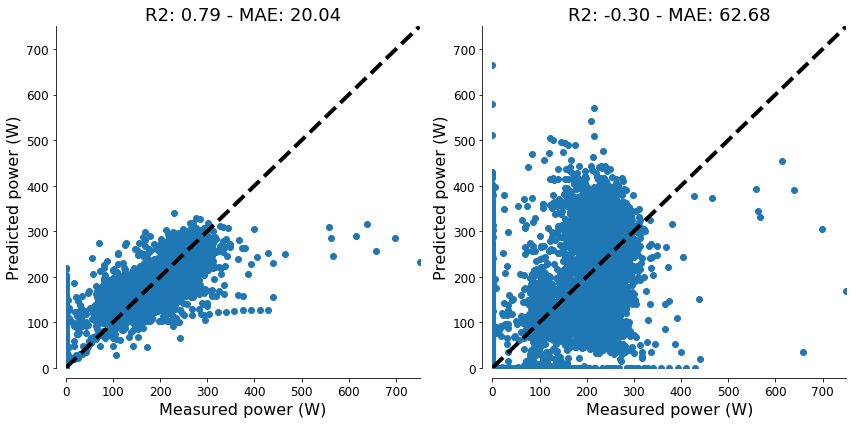

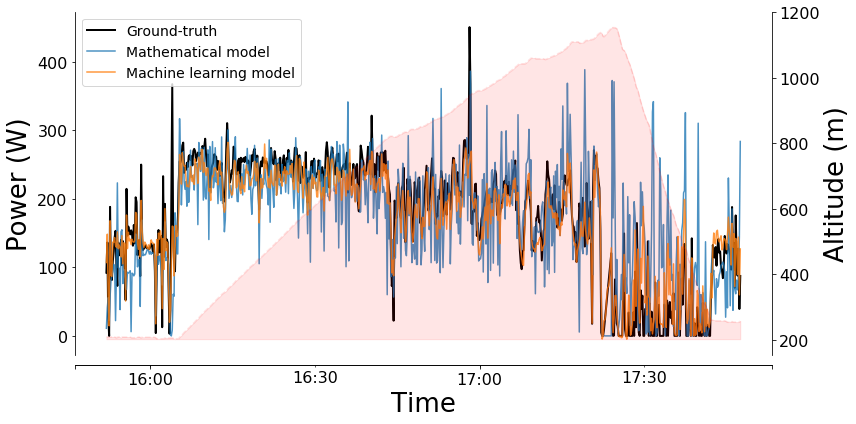

In [15]:
summary_result_ride(337, '10S')

This is also possible to focus on a specific time range

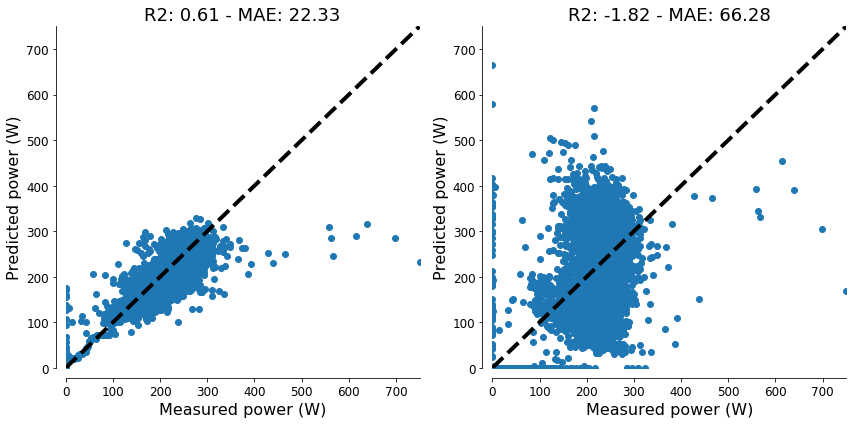

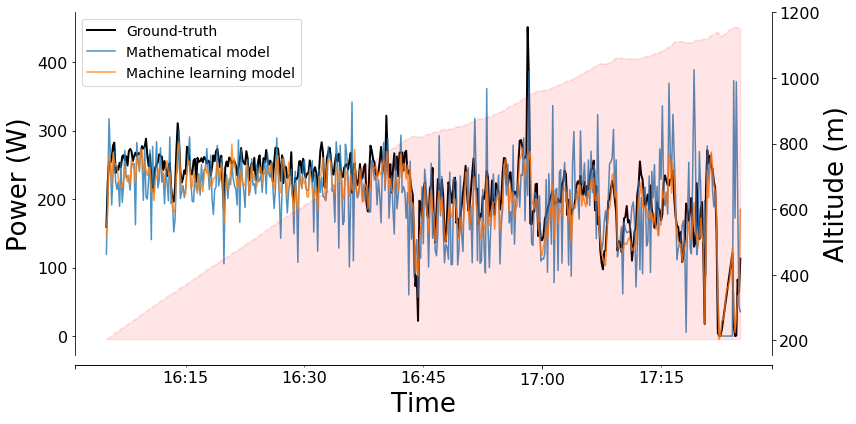

In [16]:
summary_result_ride(337, '10S', slice('16:05:00','17:25:00'))